# The data

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format='retina'
pd.plotting.register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

# TYPE_ACCELEROMETER

df = pd.read_csv('data_training/training_dataset.csv', header=None, names=column_names)

df = df.dropna()

In [3]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,train1,feature_4,714865447863,-0.626533,-3.276222,-9.349377
1,train1,feature_4,714885070623,0.001088,-3.245080,-9.967416
2,train1,feature_4,714904662915,0.317294,-3.048650,-9.936275
3,train1,feature_4,714924285727,0.377182,-2.696511,-9.778172
4,train1,feature_4,714943847498,0.820349,-2.480916,-9.629650


In [4]:
df.shape

(20648, 6)

# Exploration

<Axes: xlabel='activity', ylabel='count'>

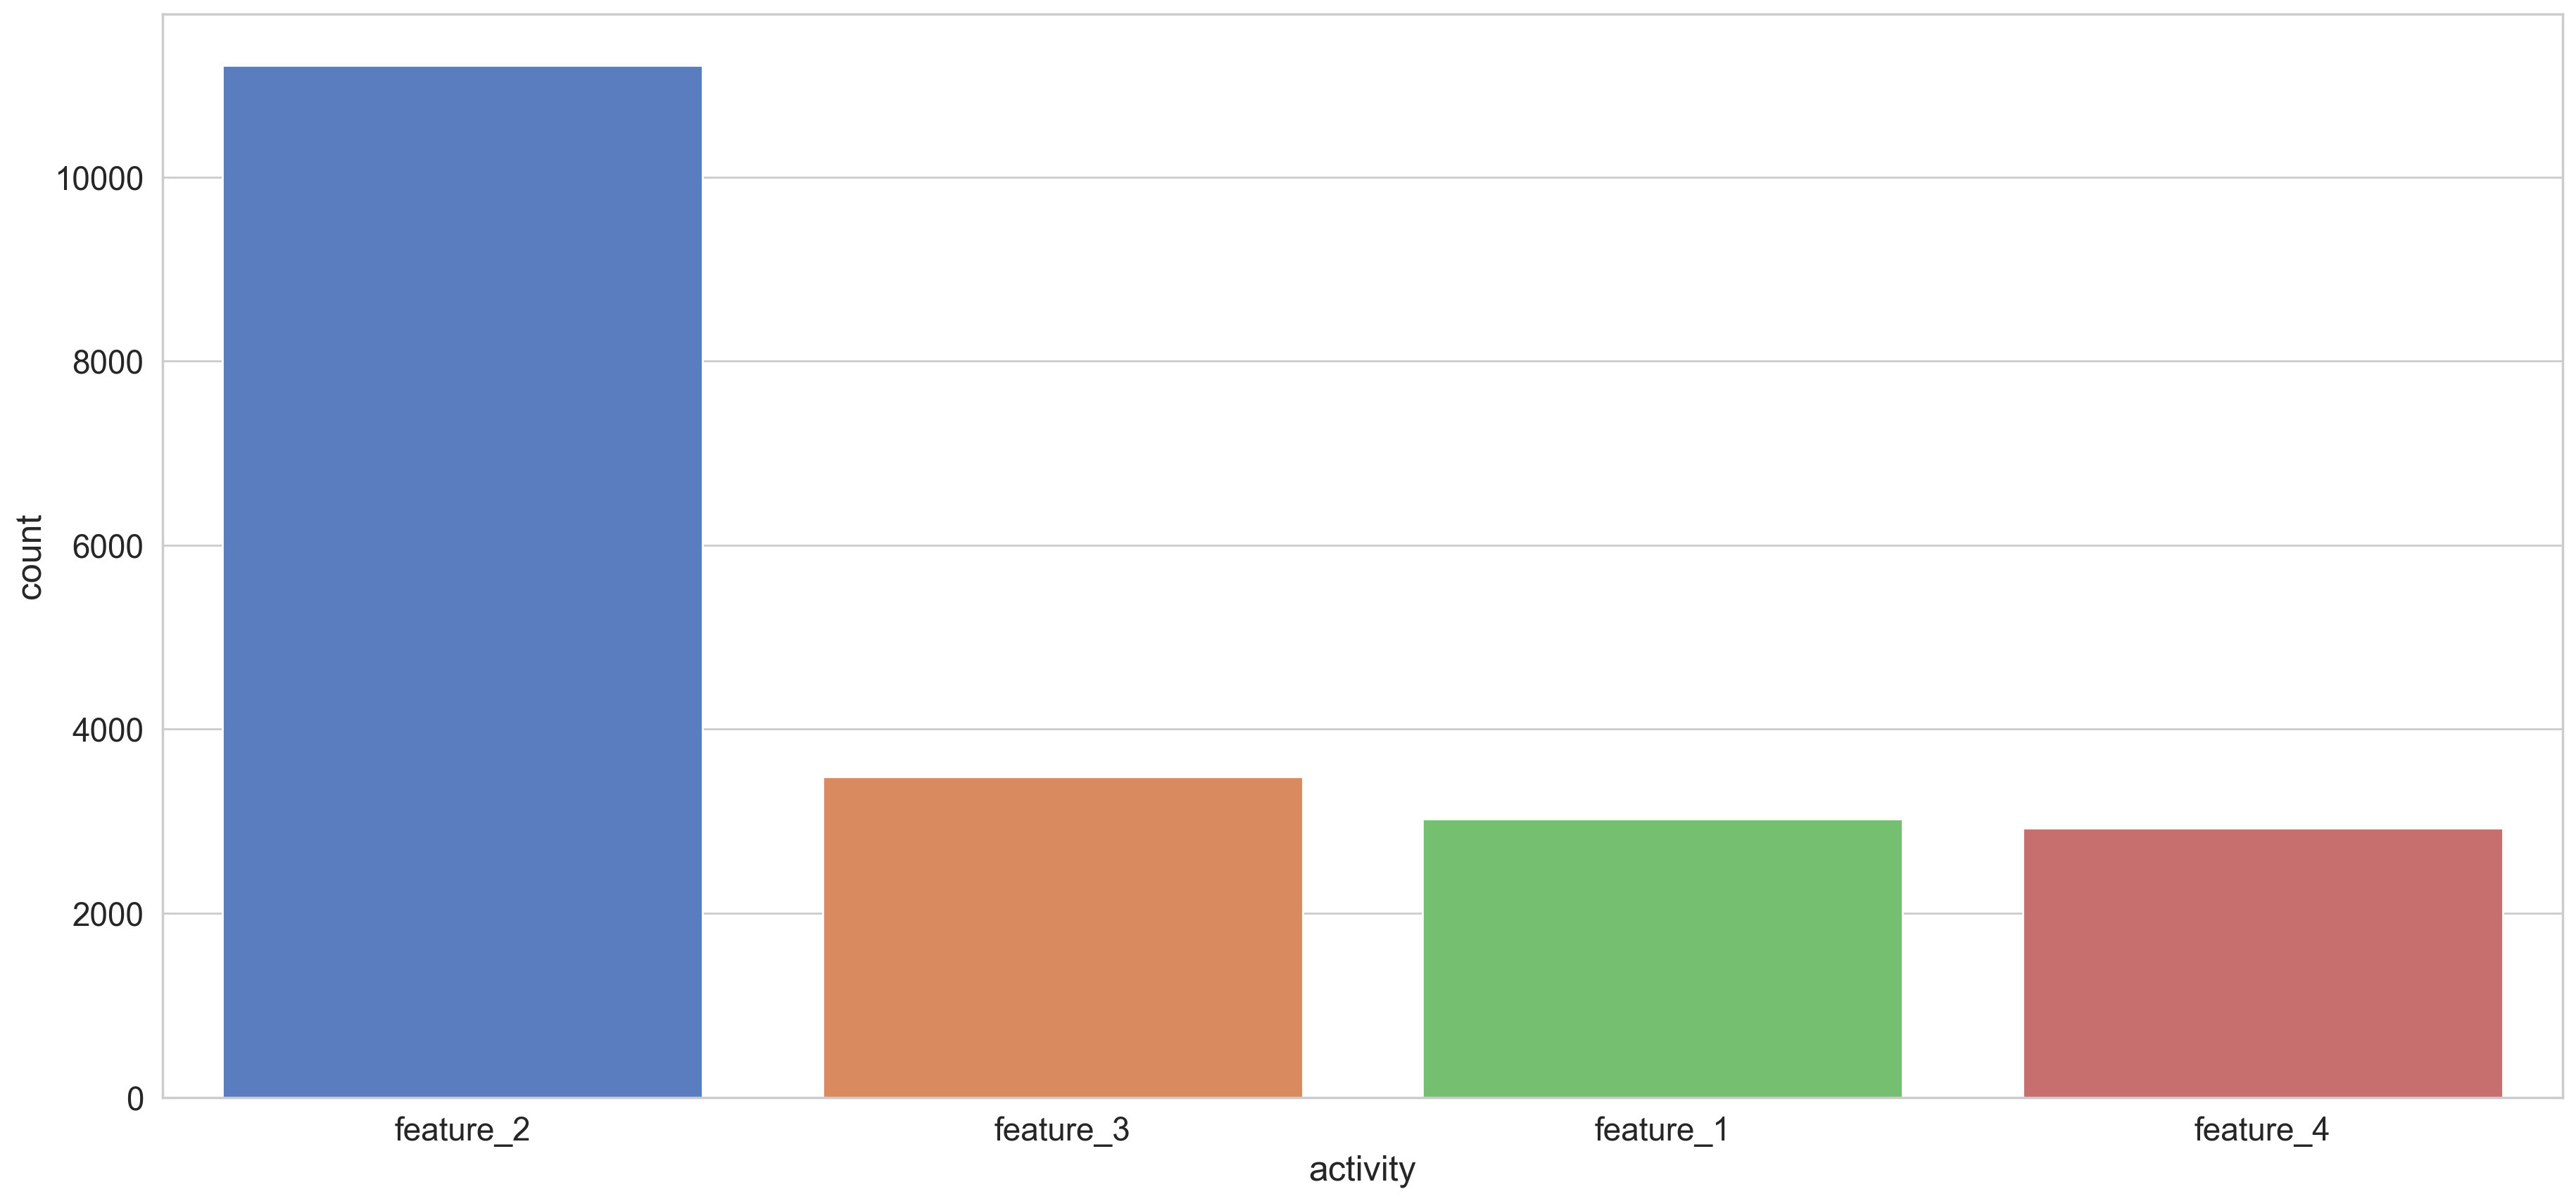

In [5]:
sns.countplot(x = 'activity',
              data = df,
              order = df.activity.value_counts().index)

Text(0.5, 1.0, 'Records per user')

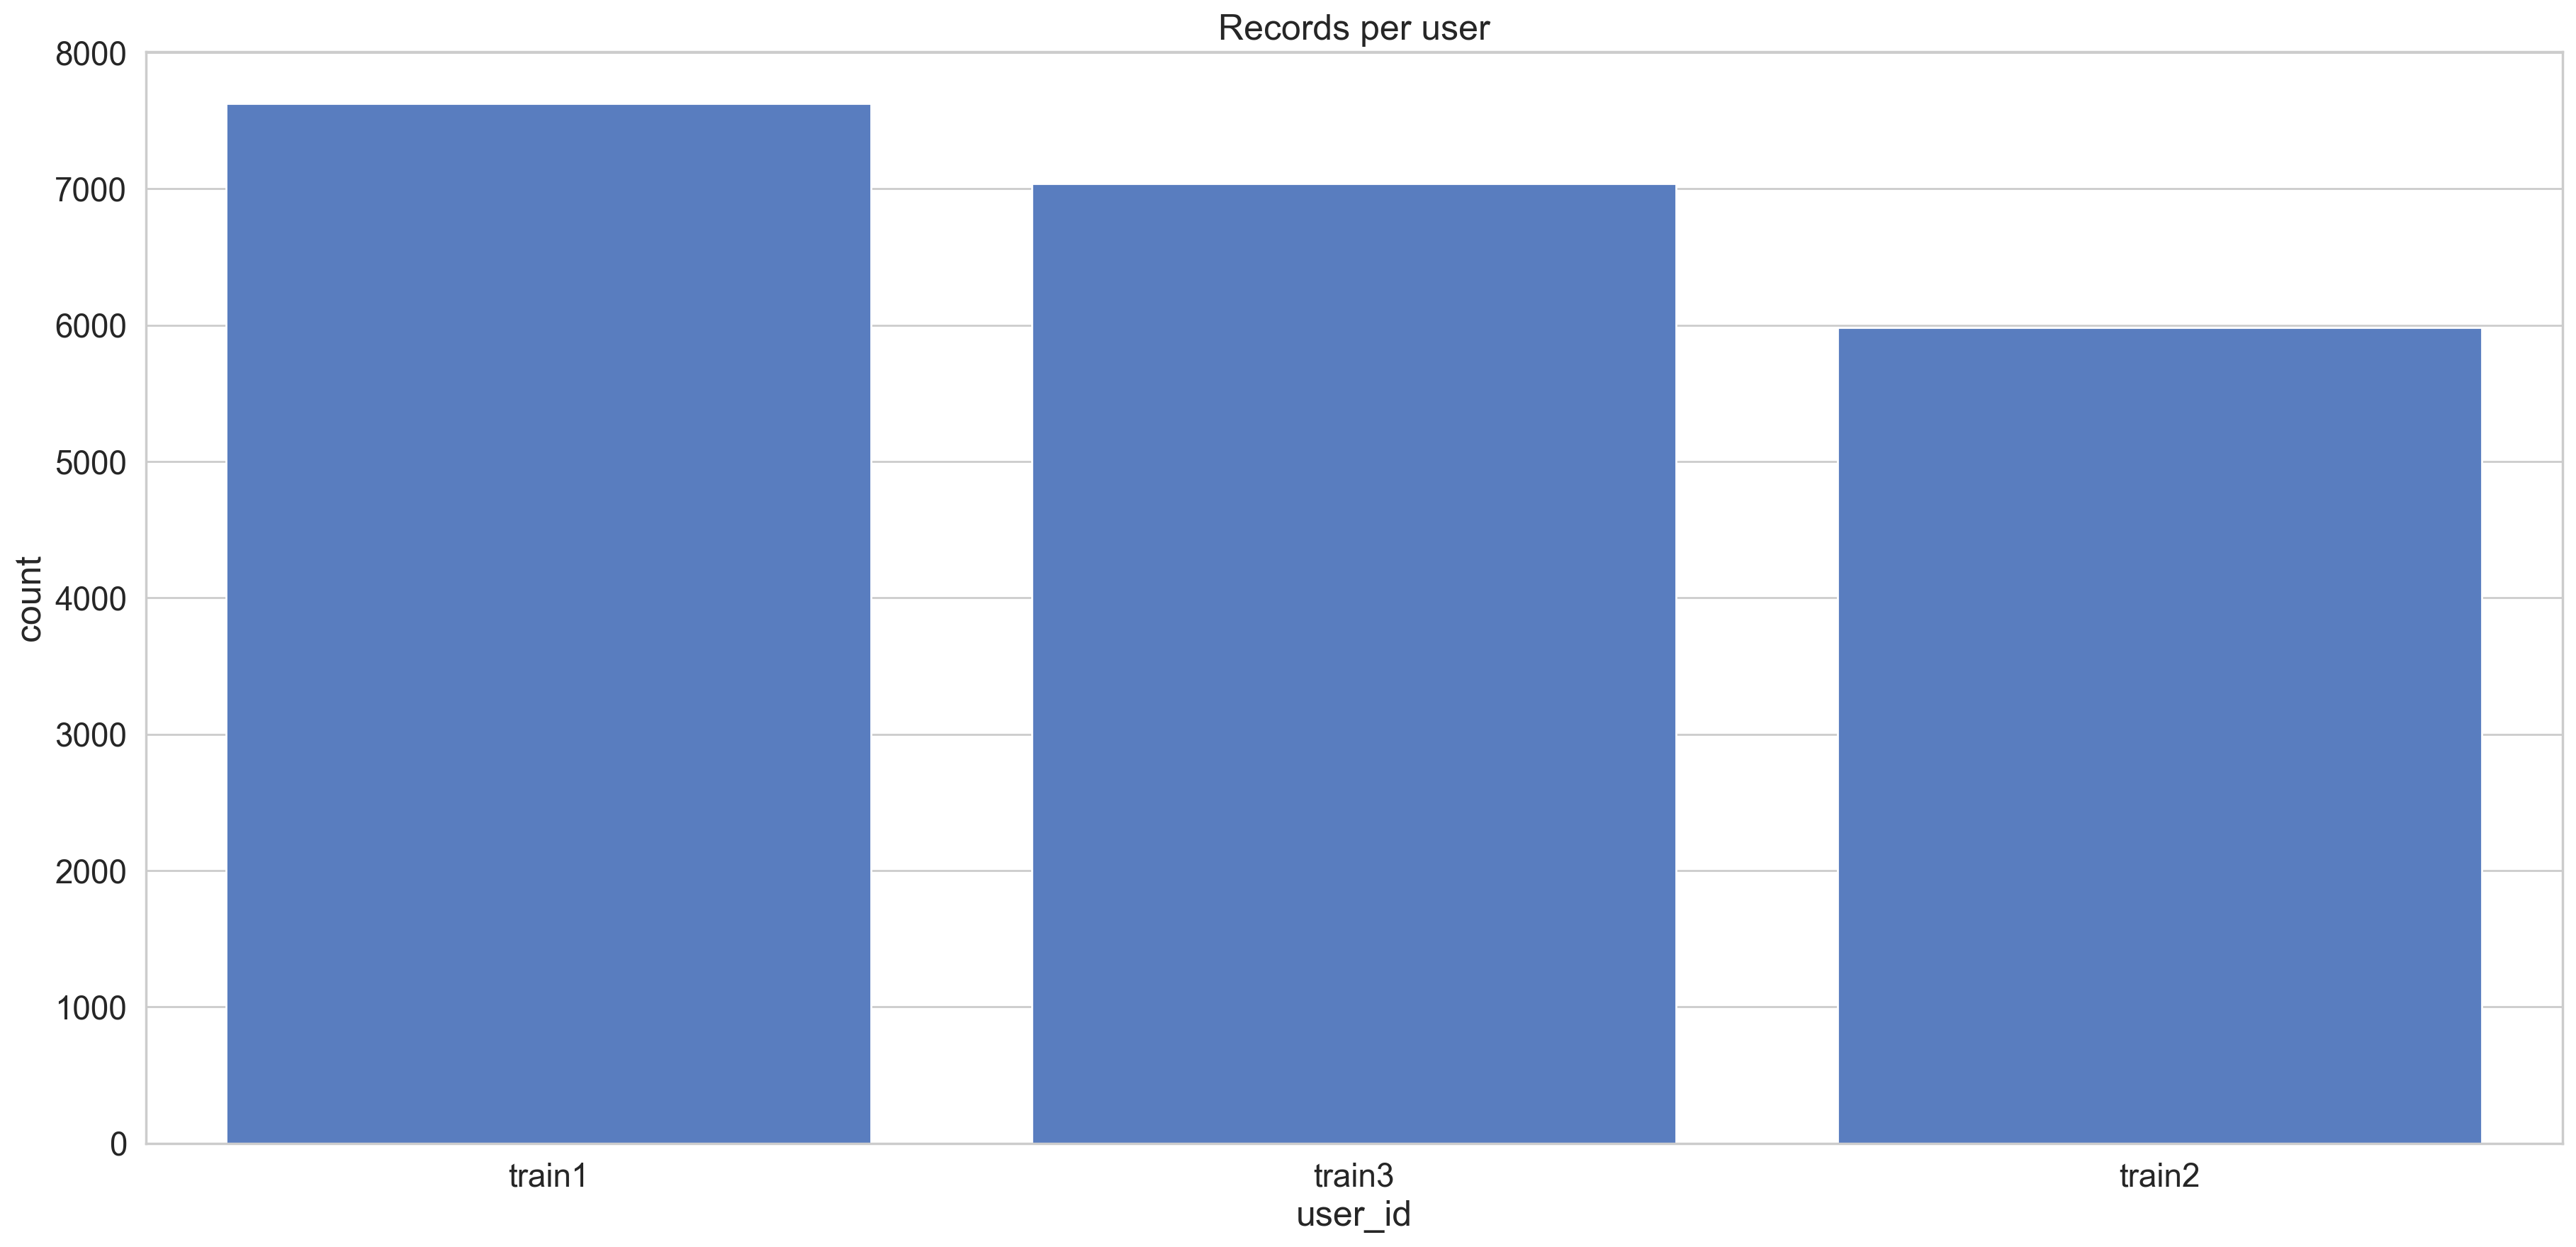

In [6]:
sns.countplot(x = 'user_id',
              data = df,
              palette=[sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user")

In [16]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x_axis', 'y_axis', 'z_axis']][:200]
    axis = data.plot(subplots=True, figsize=(8, 4), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

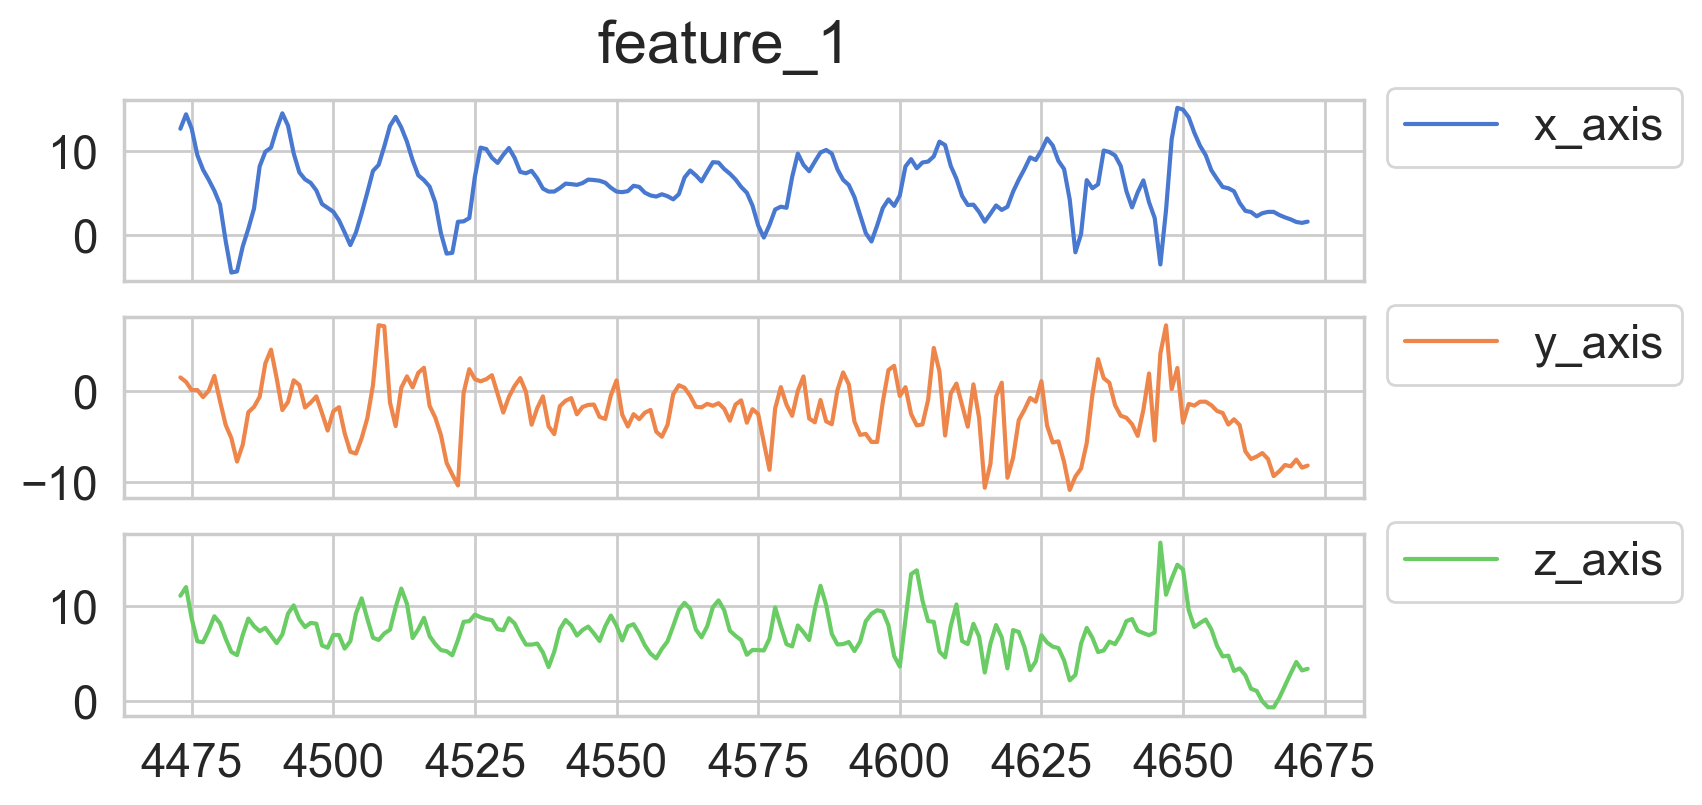

In [17]:
plot_activity("feature_1", df)

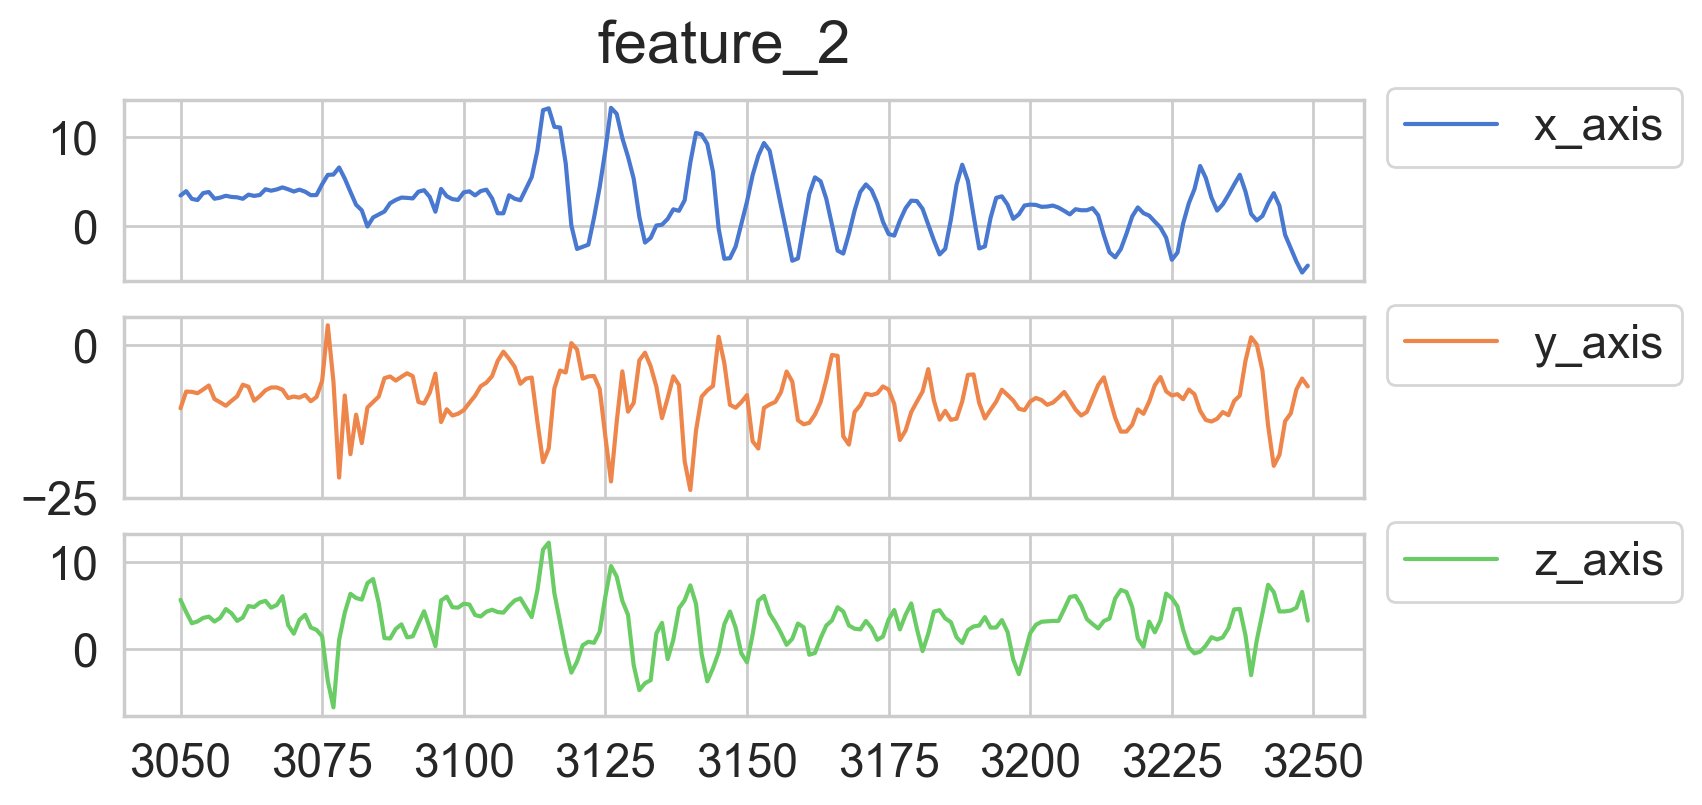

In [18]:
plot_activity("feature_2", df)

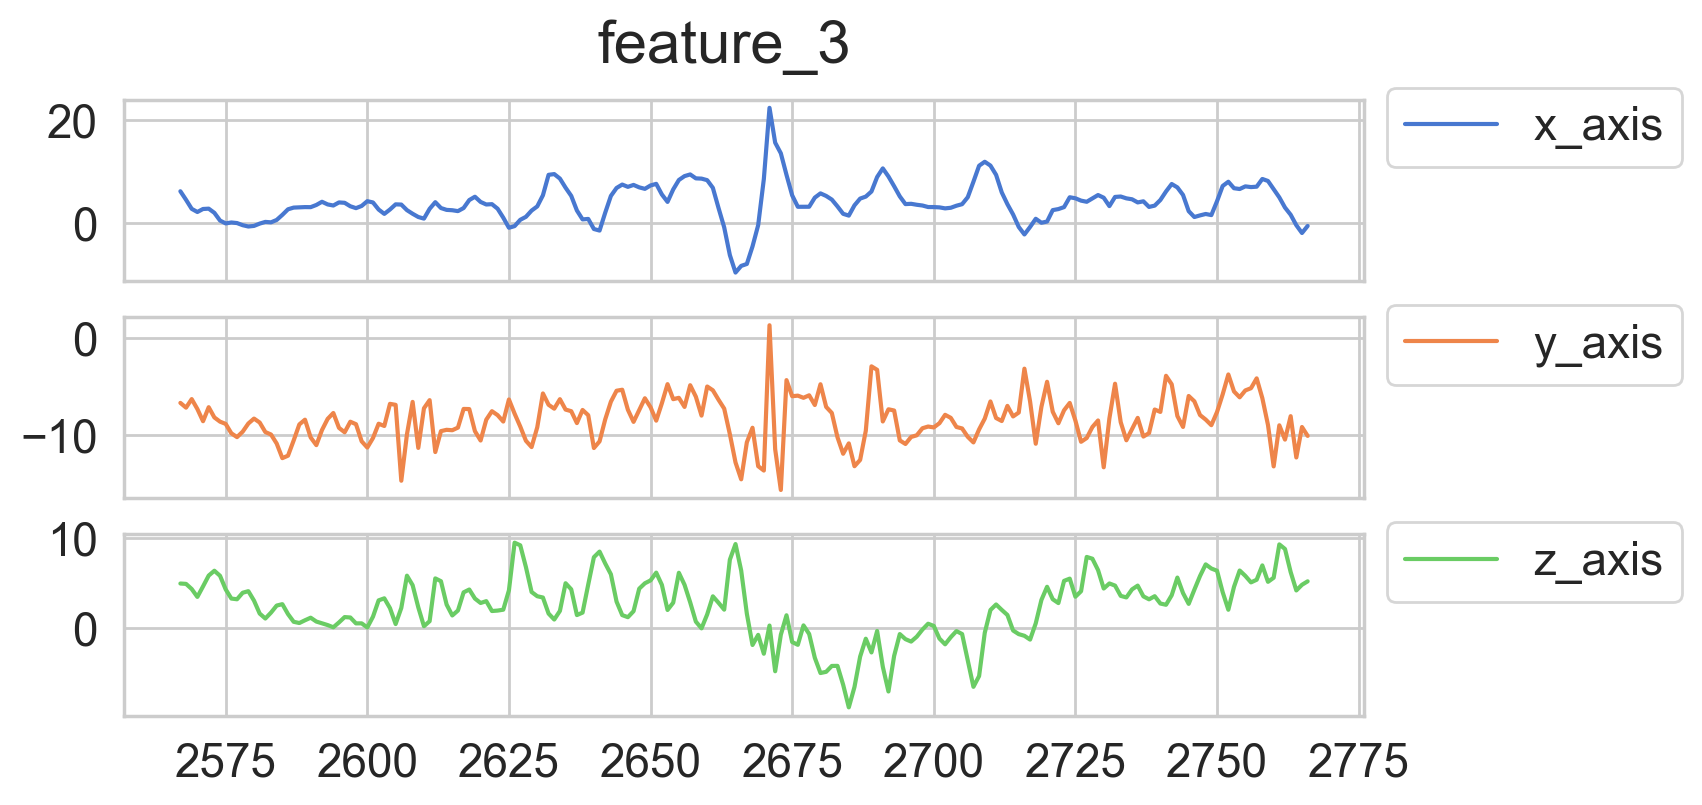

In [19]:
plot_activity("feature_3", df)

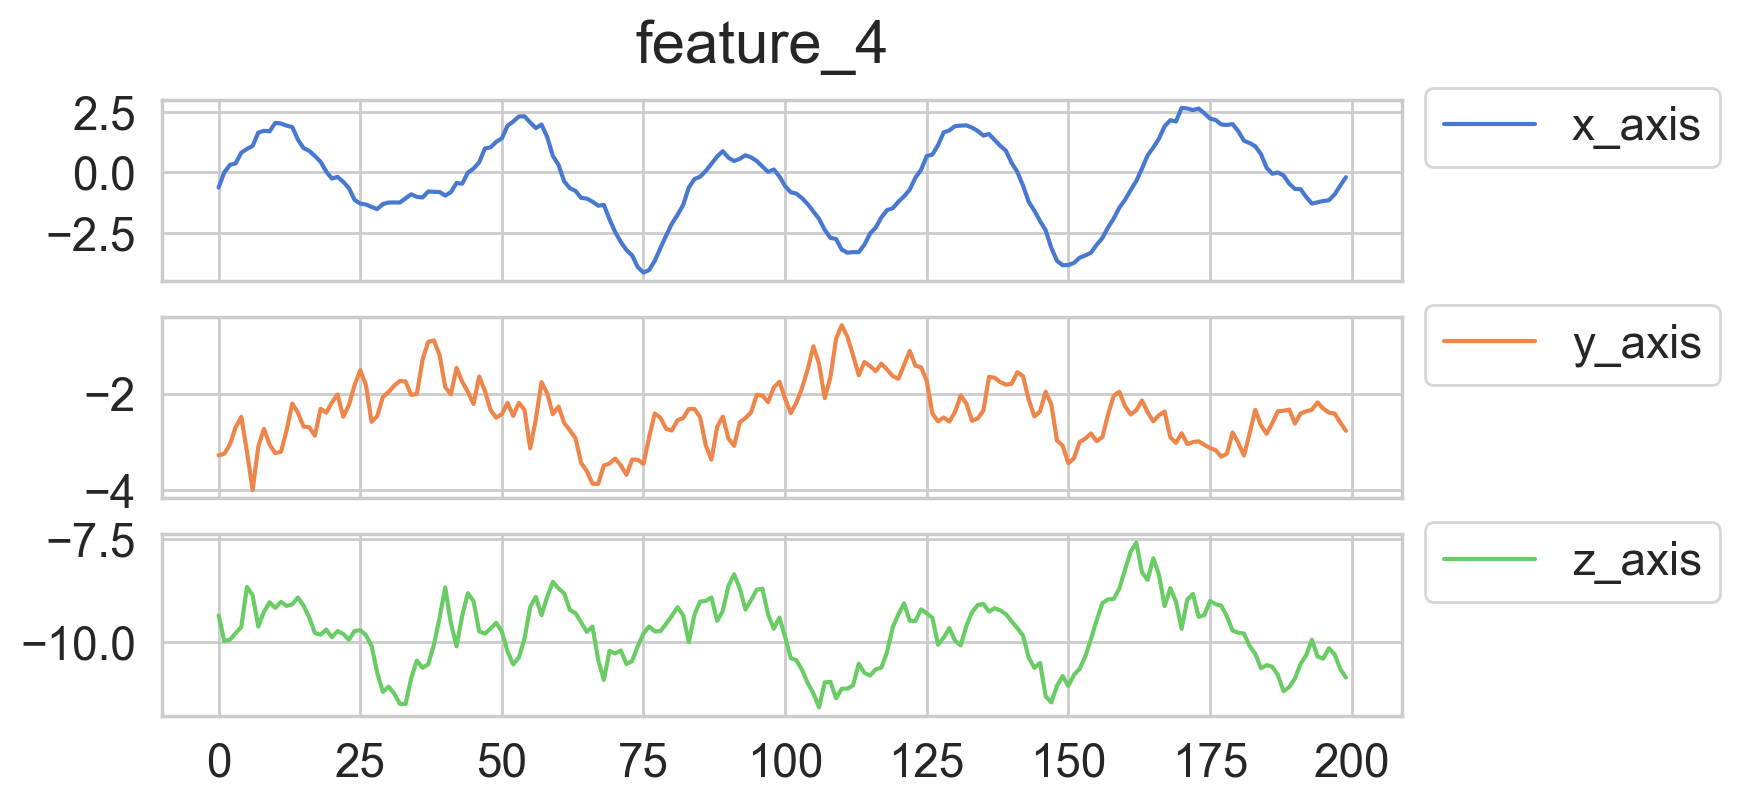

In [20]:
plot_activity("feature_4", df)

# Data preprocessing

In [12]:
df_train = df[df['user_id'] != 'train3']
df_test = df[df['user_id'] == 'train3']

In [13]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

#200 samples in 4 seconds
TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']],
    df_train.activity,
    TIME_STEPS,
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']],
    df_test.activity,
    TIME_STEPS,
    STEP
)

C:\Users\YQ\AppData\Local\Temp\ipykernel_2840\2536694605.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
C:\Users\YQ\AppData\Local\Temp\ipykernel_2840\2536694605.py:7: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  ys.append(stats.mode(labels)[0][0])
C:\Users\YQ\AppData\Local\Temp\ipykernel_2840\2536694605.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the de

In [14]:
print(X_train.shape, y_train.shape)

(336, 200, 3) (336, 1)


In [15]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

c:\Users\YQ\PythonProjects\HAR-with-TensorFlow\env\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [16]:
print(X_train.shape, y_train.shape)

(336, 200, 3) (336, 4)


In [17]:
print(X_test.shape, y_test.shape)

(171, 200, 3) (171, 4)


# Building the model

In [22]:
# LSTM

model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(units=128, input_shape=(200,3))
    ),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Training the model

In [26]:
history = model.fit(
    X_train,
    y_train,
    epochs=34,
    batch_size=800,
    validation_data=(X_test,y_test),
    shuffle=True
)

Epoch 1/34
1/1 [==============================] - 9s 9s/step - loss: 1.4557 - acc: 0.2292 - val_loss: 1.0502 - val_acc: 0.7427
Epoch 2/34
1/1 [==============================] - 2s 2s/step - loss: 1.1293 - acc: 0.5387 - val_loss: 0.8630 - val_acc: 0.7368
Epoch 3/34
1/1 [==============================] - 2s 2s/step - loss: 0.9282 - acc: 0.6935 - val_loss: 0.7729 - val_acc: 0.7251
Epoch 4/34
1/1 [==============================] - 2s 2s/step - loss: 0.8622 - acc: 0.6845 - val_loss: 0.7097 - val_acc: 0.7427
Epoch 5/34
1/1 [==============================] - 2s 2s/step - loss: 0.7957 - acc: 0.6875 - val_loss: 0.6514 - val_acc: 0.7544
Epoch 6/34
1/1 [==============================] - 2s 2s/step - loss: 0.7421 - acc: 0.7232 - val_loss: 0.6019 - val_acc: 0.7778
Epoch 7/34
1/1 [==============================] - 2s 2s/step - loss: 0.6933 - acc: 0.7202 - val_loss: 0.5734 - val_acc: 0.7953
Epoch 8/34
1/1 [==============================] - 2s 2s/step - loss: 0.6631 - acc: 0.7500 - val_loss: 0.5680 - 

In [27]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 256)               135168    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 168,580
Trainable params: 168,580
Non-trainable params: 0
_________________________________________________________________
None


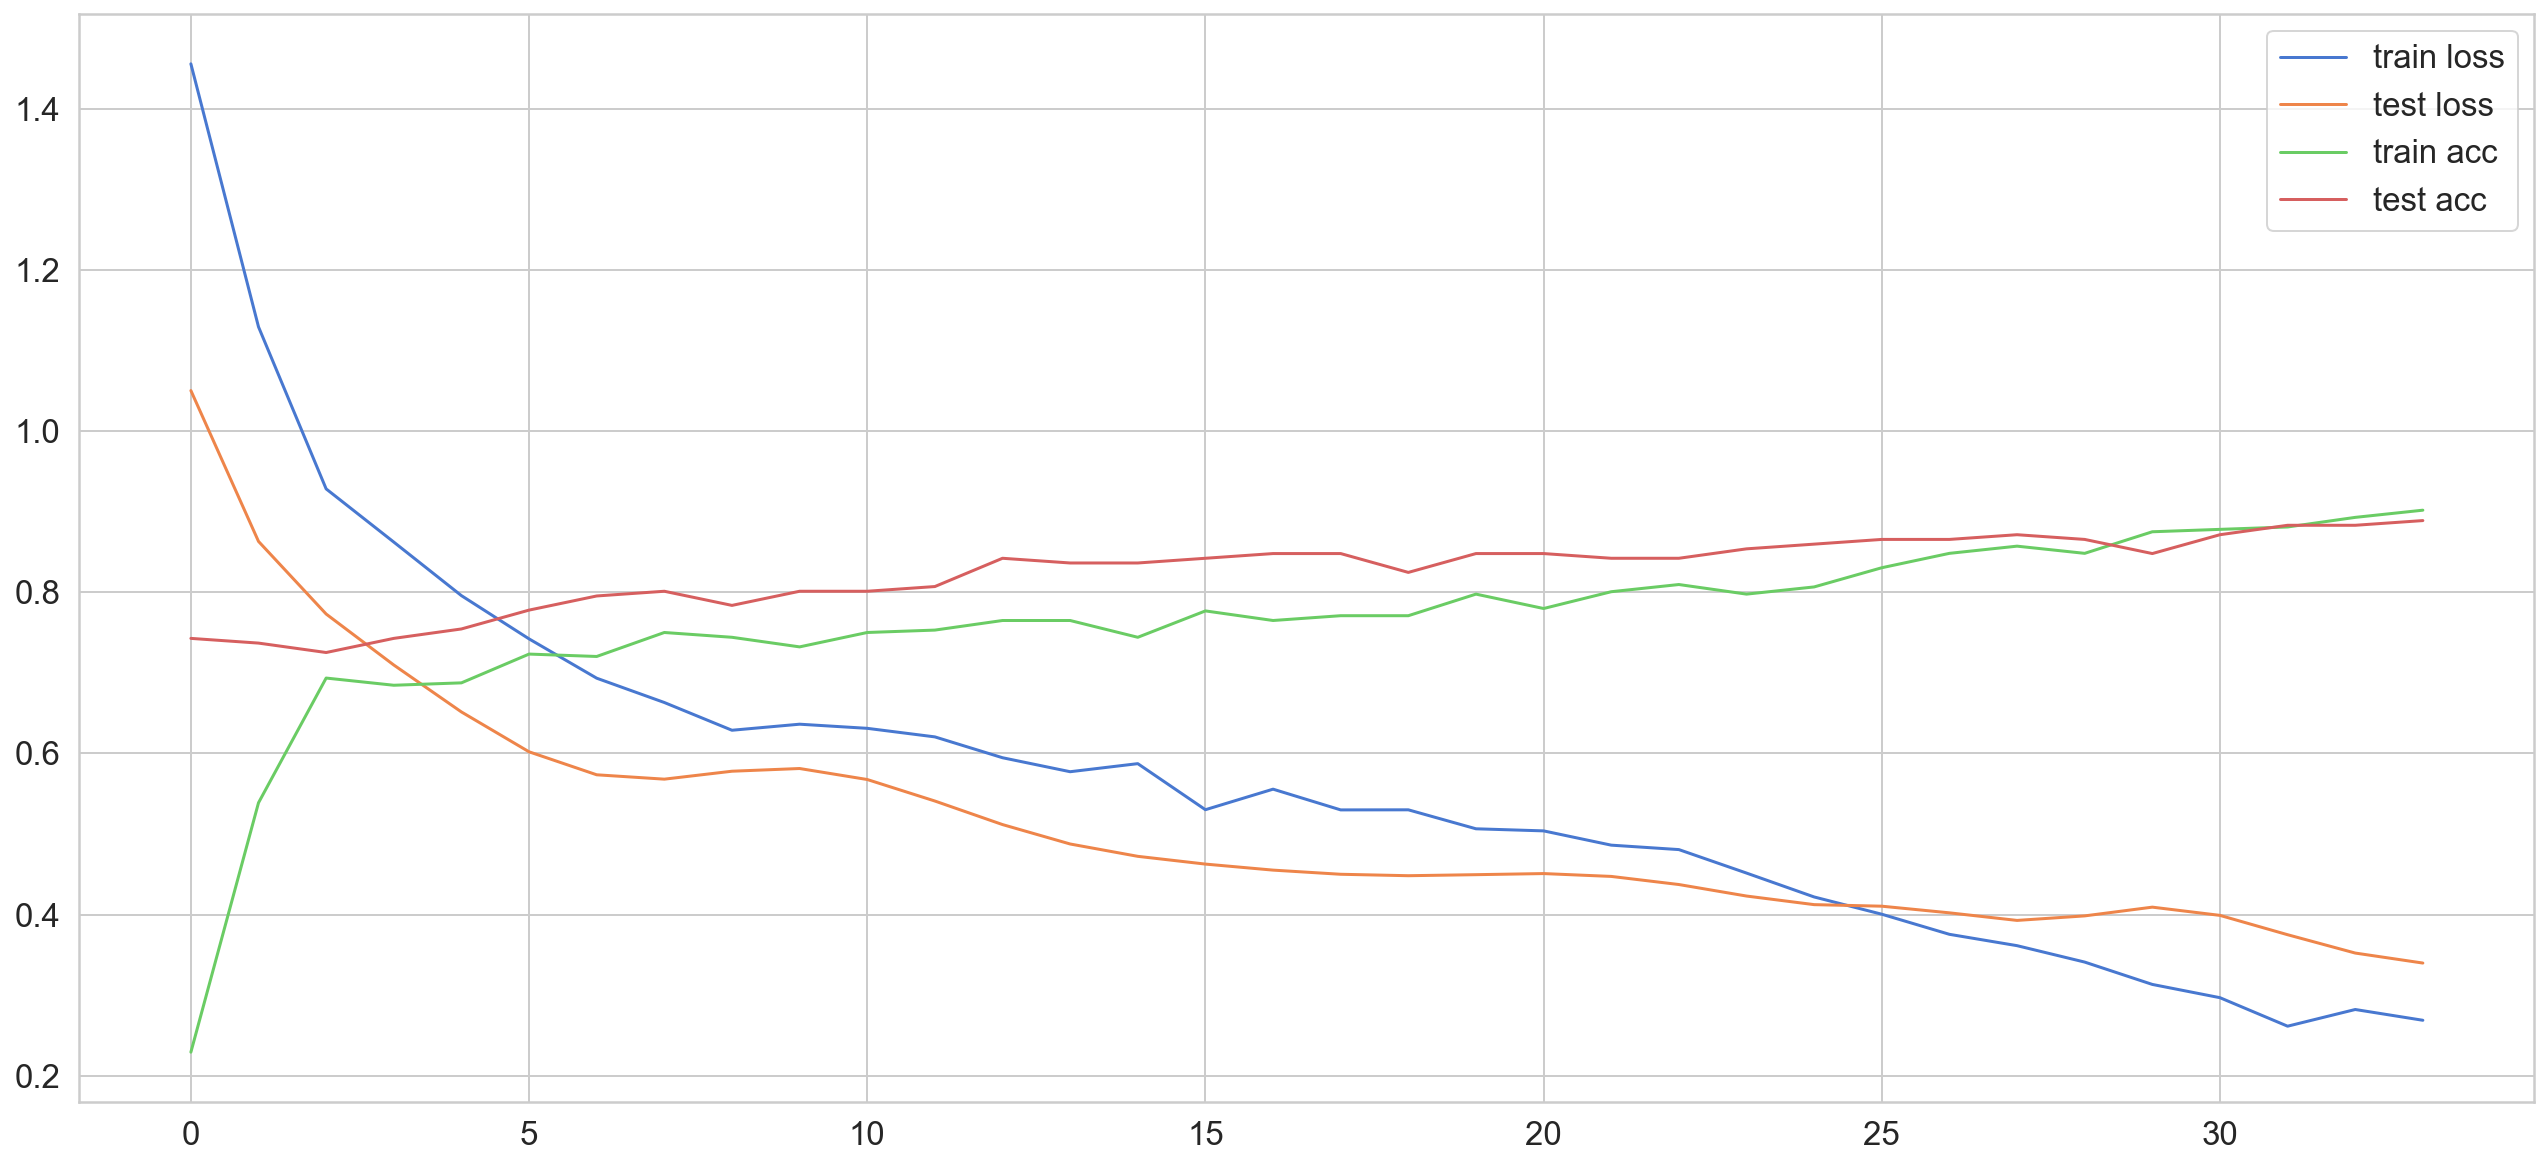

In [28]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='test acc')
plt.legend()

# Evaluation

In [29]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

6/6 [==============================] - 0s 62ms/step - loss: 0.3398 - acc: 0.8889
Test accuracy 0.8888888955116272
Test loss 0.33976808190345764


In [30]:
y_pred = model.predict(X_test)

6/6 [==============================] - 1s 83ms/step


In [31]:
def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(9, 8))
  ax = sns.heatmap(
      cm,
      annot=True,
      fmt="d",
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show()

Confusion Matrix


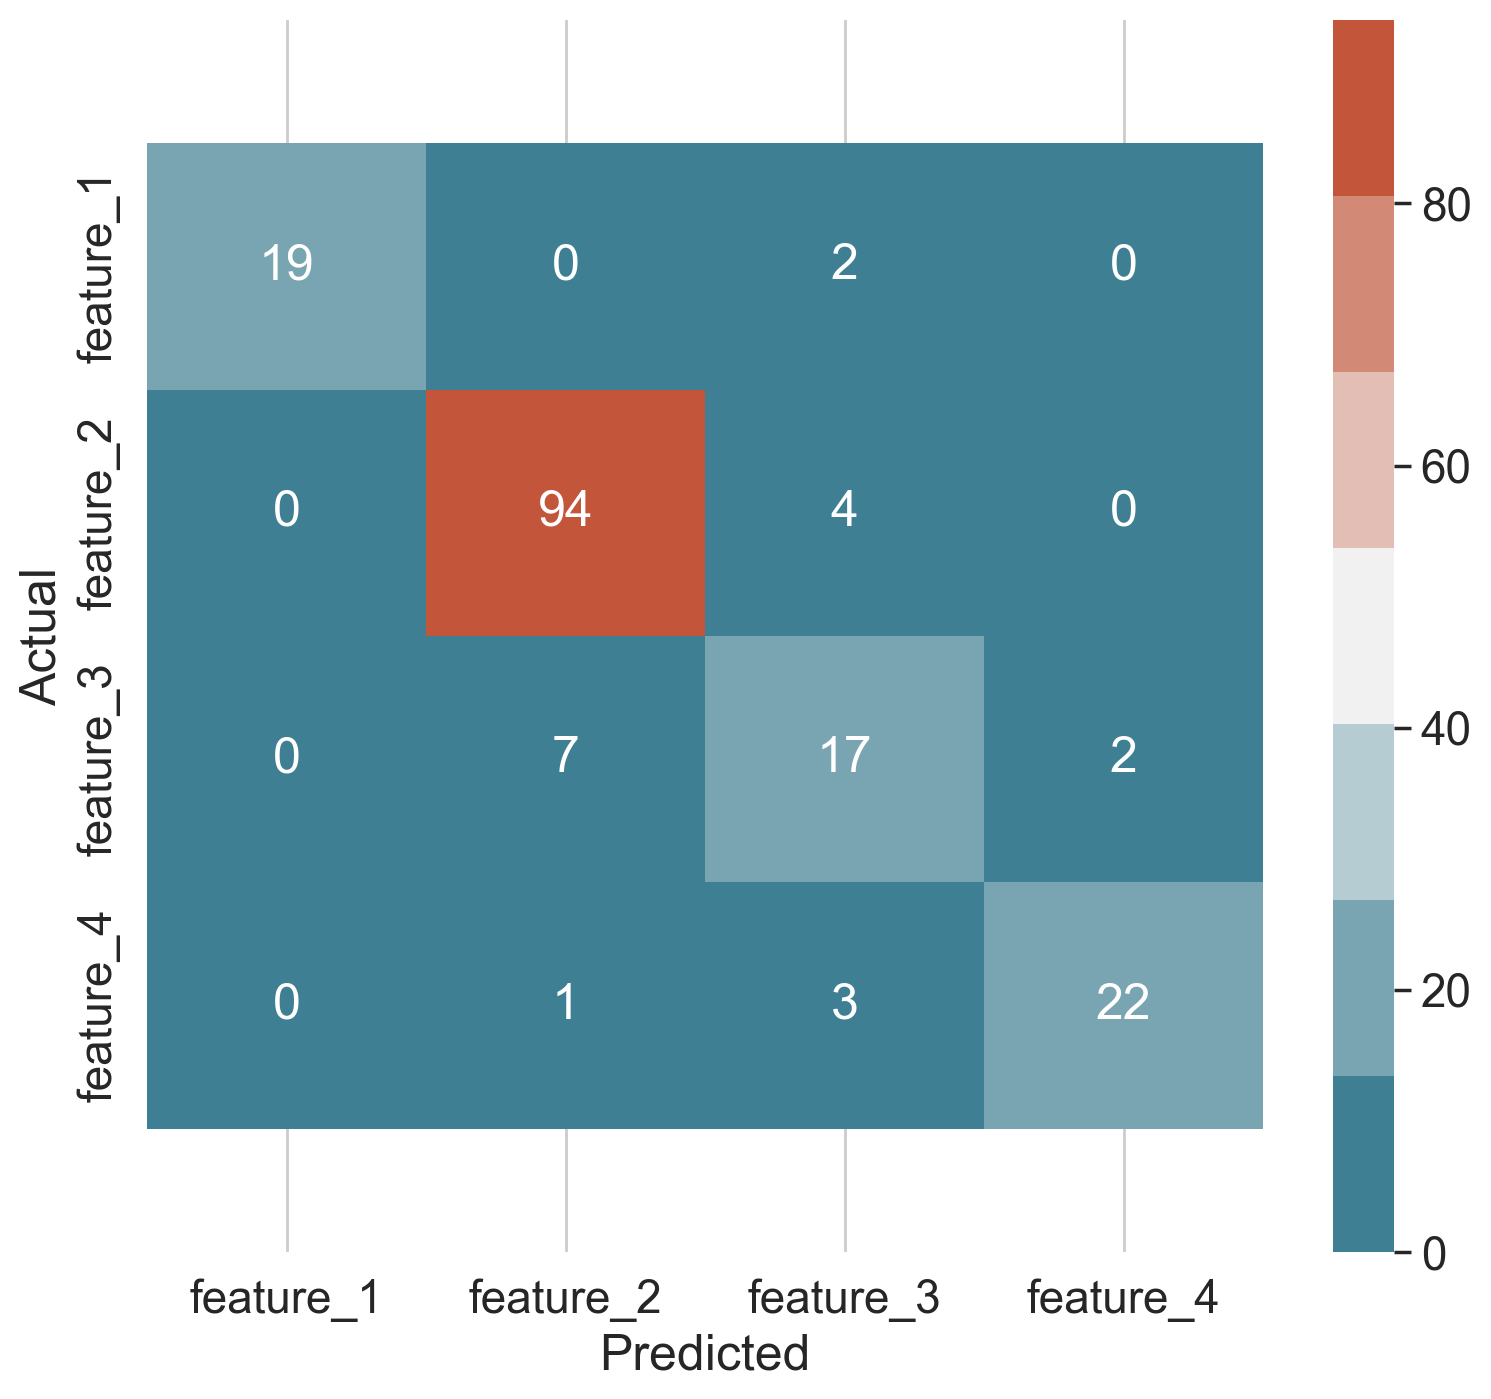

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.92      0.96      0.94        98
           2       0.65      0.65      0.65        26
           3       0.92      0.85      0.88        26

    accuracy                           0.89       171
   macro avg       0.87      0.84      0.86       171
weighted avg       0.89      0.89      0.89       171



In [32]:
print('Confusion Matrix')
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)
print('Classification Report')
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

# Saving the model

In [33]:
model.save("gesture_recognizer/acc_position_lstm.h5")

# Loading the model

In [34]:
model = keras.models.load_model("gesture_recognizer/acc_position_lstm.h5")

# Converting the model

In [35]:
# Convert the model to tflite.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# save as tflite format
with open('gesture_recognizer/acc_position_lstm.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\YQ\AppData\Local\Temp\tmpn5ysd8qk\assets


INFO:tensorflow:Assets written to: C:\Users\YQ\AppData\Local\Temp\tmpn5ysd8qk\assets


# Input and Output of the model

In [37]:
interpreter = tf.lite.Interpreter(model_path="gesture_recognizer/acc_position_lstm.tflite")
interpreter.allocate_tensors()

# Print input shape and type
inputs = interpreter.get_input_details()
print('{} input(s):'.format(len(inputs)))
for i in range(0, len(inputs)):
    print('{} {}'.format(inputs[i]['shape'], inputs[i]['dtype']))

# Print output shape and type
outputs = interpreter.get_output_details()
print('\n{} output(s):'.format(len(outputs)))
for i in range(0, len(outputs)):
    print('{} {}'.format(outputs[i]['shape'], outputs[i]['dtype']))

1 input(s):
[  1 200   3] <class 'numpy.float32'>

1 output(s):
[1 4] <class 'numpy.float32'>
